In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from copy import deepcopy as dc
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [9]:
data = pd.read_csv('retail_sales.csv')
data

,Date,Sales
0,1/1/15 0:00,54.048619
1,1/1/15 1:00,50.161596
2,1/1/15 2:00,55.954939
3,1/1/15 3:00,56.553261
4,1/1/15 4:00,60.487874
...,...,...
52580,30/12/20 20:00,140.946779
52581,30/12/20 21:00,145.561324
52582,30/12/20 22:00,144.484071
52583,30/12/20 23:00,147.890291


In [10]:
data = data[['Date','Sales']]
data

,Date,Sales
0,1/1/15 0:00,54.048619
1,1/1/15 1:00,50.161596
2,1/1/15 2:00,55.954939
3,1/1/15 3:00,56.553261
4,1/1/15 4:00,60.487874
...,...,...
52580,30/12/20 20:00,140.946779
52581,30/12/20 21:00,145.561324
52582,30/12/20 22:00,144.484071
52583,30/12/20 23:00,147.890291


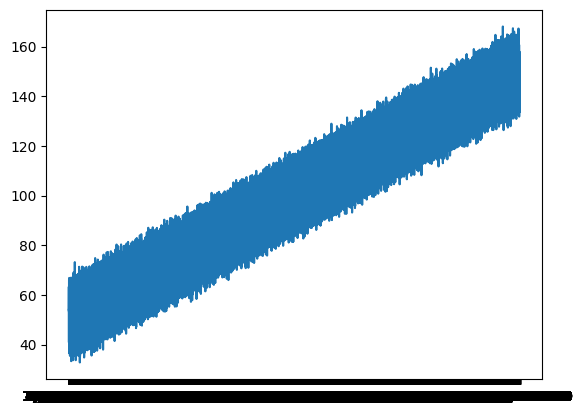

In [11]:
plt.plot(data['Date'], data['Sales'])

In [12]:
#weeklu closure
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df['Date'] = pd.to_datetime(df['Date'])

  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'close(t-{i})'] = df['Sales'].shift(i)

  df.dropna(inplace=True)

  return df

In [13]:
lookback = 5
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

<ipython-input-12-11b1e7d636fa>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Sales,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5)
Date,,,,,,
2015-01-01 05:00:00,60.773704,60.487874,56.553261,55.954939,50.161596,54.048619
2015-01-01 06:00:00,59.824278,60.773704,60.487874,56.553261,55.954939,50.161596
2015-01-01 07:00:00,61.713331,59.824278,60.773704,60.487874,56.553261,55.954939
2015-01-01 08:00:00,63.275942,61.713331,59.824278,60.773704,60.487874,56.553261
2015-01-01 09:00:00,57.607092,63.275942,61.713331,59.824278,60.773704,60.487874
...,...,...,...,...,...,...
2020-12-30 20:00:00,140.946779,142.827011,141.859094,138.293731,141.431344,139.665995
2020-12-30 21:00:00,145.561324,140.946779,142.827011,141.859094,138.293731,141.431344
2020-12-30 22:00:00,144.484071,145.561324,140.946779,142.827011,141.859094,138.293731


In [14]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 60.77370366,  60.48787351,  56.55326085,  55.95493896,
         50.16159636,  54.04861925],
       [ 59.82427795,  60.77370366,  60.48787351,  56.55326085,
         55.95493896,  50.16159636],
       [ 61.71333068,  59.82427795,  60.77370366,  60.48787351,
         56.55326085,  55.95493896],
       ...,
       [144.4840706 , 145.5613237 , 140.9467795 , 142.8270109 ,
        141.8590945 , 138.2937305 ],
       [147.8902907 , 144.4840706 , 145.5613237 , 140.9467795 ,
        142.8270109 , 141.8590945 ],
       [150.2234874 , 147.8902907 , 144.4840706 , 145.5613237 ,
        140.9467795 , 142.8270109 ]])

In [15]:
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.58639954, -0.59062413, -0.64877805, -0.6576213 , -0.7432474 ,
        -0.68579687],
       [-0.60043213, -0.58639954, -0.59062413, -0.64877805, -0.6576213 ,
        -0.7432474 ],
       [-0.57251177, -0.60043213, -0.58639954, -0.59062413, -0.64877805,
        -0.6576213 ],
       ...,
       [ 0.65084691,  0.6667688 ,  0.59856544,  0.62635542,  0.61204953,
         0.55935315],
       [ 0.70119114,  0.65084691,  0.6667688 ,  0.59856544,  0.62635542,
         0.61204953],
       [ 0.73567598,  0.70119114,  0.65084691,  0.6667688 ,  0.59856544,
         0.62635542]])

In [16]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((52580, 5), (52580,))

In [17]:
X = dc(np.flip(X,axis=1))
X

array([[-0.68579687, -0.7432474 , -0.6576213 , -0.64877805, -0.59062413],
       [-0.7432474 , -0.6576213 , -0.64877805, -0.59062413, -0.58639954],
       [-0.6576213 , -0.64877805, -0.59062413, -0.58639954, -0.60043213],
       ...,
       [ 0.55935315,  0.61204953,  0.62635542,  0.59856544,  0.6667688 ],
       [ 0.61204953,  0.62635542,  0.59856544,  0.6667688 ,  0.65084691],
       [ 0.62635542,  0.59856544,  0.6667688 ,  0.65084691,  0.70119114]])

In [18]:
split_index = int(len(X) * 0.95) #95% train, 5% test
split_index

49951

In [19]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49951, 5), (2629, 5), (49951,), (2629,))

In [20]:
#reshaping the data
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49951, 5, 1), (2629, 5, 1), (49951, 1), (2629, 1))

In [21]:
#creating tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([49951, 5, 1]),
 torch.Size([2629, 5, 1]),
 torch.Size([49951, 1]),
 torch.Size([2629, 1]))

In [22]:
#creating tensor dataset
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [23]:
#creating batches from the new dataset
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [24]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device) #our device?
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([8, 5, 1]) torch.Size([8, 1])


In [25]:
#creating lstm model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_layers = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_layers).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_layers).to(device)
    out, _ =self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
#epochs training function
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch + 1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99: #print every 100 batches
      avg_loss_across_batches = running_loss / 100
#       print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
#                                              avg_loss_across_batches))
      running_loss = 0.0
#   print()

In [27]:
#epochs evaluation function
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss

    avg_loss_across_batches = running_loss/len(test_loader)

#     print('Val Loss : {0:.3f}'.format(avg_loss_across_batches))
#     print('*****************************')
#     print()

In [28]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30


In [29]:
torch.save(model, "model.pt")
model1 = torch.load("model.pt")
model1.eval()

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

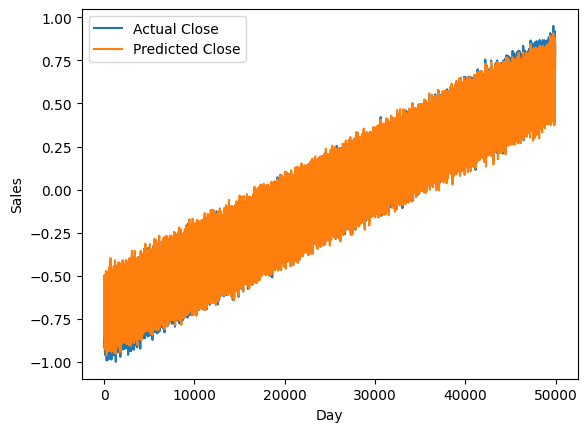

In [30]:
with torch.no_grad():
  predicted = model1(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [31]:
#unscaling the values
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([ 61.45805518,  63.02572884,  61.88297574, ..., 153.86078158,
       154.380452  , 148.13171175])

In [32]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([ 60.77370268,  59.8242764 ,  61.71332933, ..., 157.61542479,
       150.05922115, 152.9799325 ])

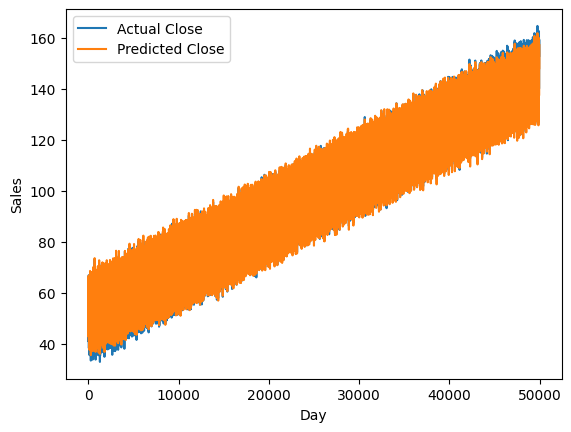

In [33]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [34]:
#checking the model on the test data
test_predictions = model1(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

array([148.66741646, 145.16183693, 139.99131341, ..., 144.19382767,
       144.25598067, 146.7602806 ])

In [35]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([147.60946439, 143.05657123, 141.41020619, ..., 144.48406994,
       147.89029016, 150.22348785])

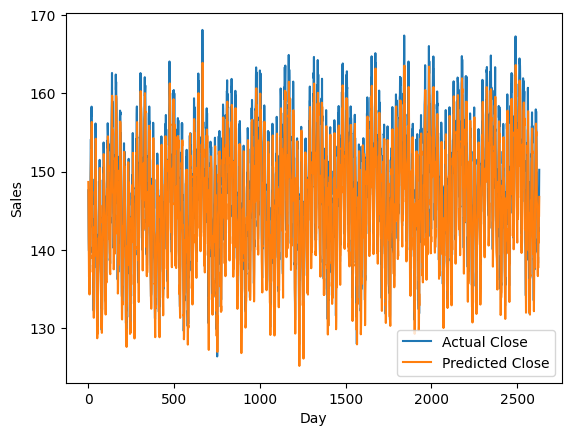

In [36]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.legend()
plt.show()